In [1]:
#!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb
import optuna

In [3]:
train_data=pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test_data=pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')


In [4]:
train_data['Hardness'].describe()

count    10407.000000
mean         4.647126
std          1.680525
min          1.000000
25%          3.000000
50%          5.500000
75%          6.000000
max         10.000000
Name: Hardness, dtype: float64

In [5]:
train_data.head(2)

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.86,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.91,0.492719,0.71760,6.5


In [6]:
train_data.columns = train_data.columns.str.lower()
train_data.head(2)

,id,allelectrons_total,density_total,allelectrons_average,val_e_average,atomicweight_average,ionenergy_average,el_neg_chi_average,r_vdw_element_average,r_cov_element_average,zaratio_average,density_average,hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.86,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.91,0.492719,0.71760,6.5


In [7]:
train_data.drop(columns=['id'],inplace=True)
train_data.head(2)

,allelectrons_total,density_total,allelectrons_average,val_e_average,atomicweight_average,ionenergy_average,el_neg_chi_average,r_vdw_element_average,r_cov_element_average,zaratio_average,density_average,hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.86,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.91,0.492719,0.71760,6.5


In [8]:
y_train = train_data['hardness']
X_train = train_data.drop(columns='hardness')

In [9]:
y = train_data['hardness']
X = train_data.drop(columns='hardness')

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)
print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 6243 samples 	 60%
Test:  2082 samples 	 20%
Val:   2082 samples 	 20%


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [12]:
from sklearn.model_selection import train_test_split


X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                  train_size=0.8,
                                                  random_state=42)
total_len = len(X_train) + len(X_val) + len(X_test)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / total_len * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / total_len * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / total_len * 100)}%')

Train: 6243 samples 	 75%
Test:  1665 samples 	 20%
Val:   417 samples 	 5%


In [13]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns


num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))])


cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),])
preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['allelectrons_total', 'density_total', 'allelectrons_average',
       'val_e_average', 'atomicweight_average', 'ionenergy_average',
       'el_neg_chi_average', 'r_vdw_element_average', 'r_cov_element_average',
       'zaratio_average', 'density_average'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index([], dtype='object'))])

In [14]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [15]:
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor


# def objective(trial):
#   """
#   Функція objective для Optuna, яка навчає модель LightGBMRegressor
#   на тренувальному наборі даних та оцінює її на тестовому наборі.

#   Args:
#       trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.

#   Returns:
#       float: Значення метрики оцінки (R2).
#   """

#   model_type = trial.suggest_categorical("model_type", ['LinReg', 'DT', 'LGBM'])

#   if model_type == 'LinReg':
#     model = LinearRegression()

#   elif model_type == 'DT':
#     model = DecisionTreeRegressor(
#         max_depth = trial.suggest_int('max_depth', 2, 12),
#         min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 100)
#     )

#   elif model_type == 'LGBM':
#     model = lgb.LGBMRegressor(
#         objective = 'mse',
#         verbose=-1,
#         boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
#         lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         num_leaves = trial.suggest_int('num_leaves', 2, 256),
#         feature_fraction = trial.suggest_float('feature_fraction', 0.2, 1.0),
#         bagging_fraction = trial.suggest_float('bagging_fraction', 0.4, 1.5),
#         bagging_freq = trial.suggest_int('bagging_freq', 0, 7),
#         min_child_samples = trial.suggest_int('min_child_samples', 5, 100),


#     )

#   # Навчання моделі на тренувальному наборі даних:

#   model.fit(X_train, y_train)

#   # Оцінка моделі на тестовому наборі даних:

#   y_pred = model.predict(X_val)
#   r2 = metrics.r2_score(y_val, y_pred)

#   # Повернення значення метрики:
#   return r2

In [16]:
from sklearn import metrics


def objective(trial):
  """
  Функція objective для Optuna, яка навчає модель LightGBMRegressor
  на тренувальному наборі даних та оцінює її на тестовому наборі.

  Args:
      trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.

  Returns:
      float: Значення метрики оцінки (R2).
  """

  # 1. Визначення гіперпараметрів:

  params = {
        'objective': 'mse',
        'n_estimator': 30,
        'verbose': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

  # 2. Створення моделі LightGBMRegressor:

  model = lgb.LGBMRegressor(**params)

  # 3. Навчання моделі на тренувальному наборі даних:

  model.fit(X_train, y_train)

  # 4. Оцінка моделі на тестовому наборі даних:

  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  # 5. Повернення значення метрики:
  return r2

In [17]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [18]:
print(f"найкраща метрика: {study.best_value}")

найкраща метрика: 0.5310350949193774


In [19]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params,
                          n_estimator = 100,
                          verbose=-1)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(bagging_fraction=0.8212955305075269, bagging_freq=1,
              feature_fraction=0.7456367127221795,
              lambda_l1=0.00784971333141108, lambda_l2=0.00032294460474756195,
              min_child_samples=28, n_estimator=100, num_leaves=25, verbose=-1)

In [20]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()
  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)
  return df.round(2)

In [21]:
all_metrics = pd.DataFrame()
all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))
all_metrics

,train,test
MAE,0.75,0.89
RMSE,1.01,1.20
R2,0.64,0.46


In [22]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

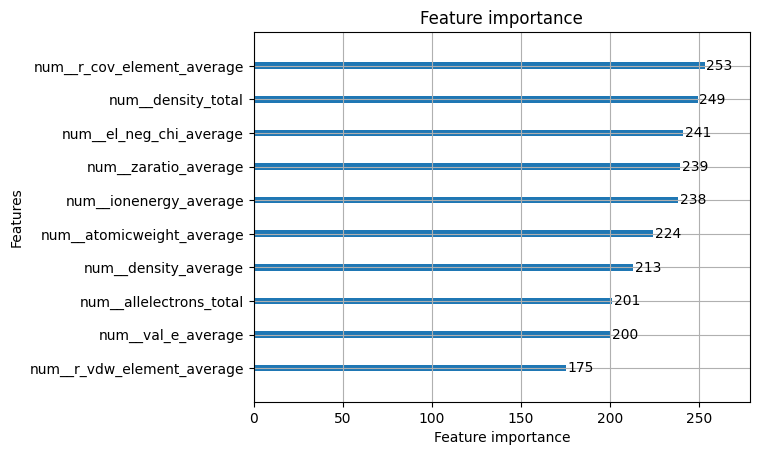

In [23]:
lgb.plot_importance(model, max_num_features=10)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

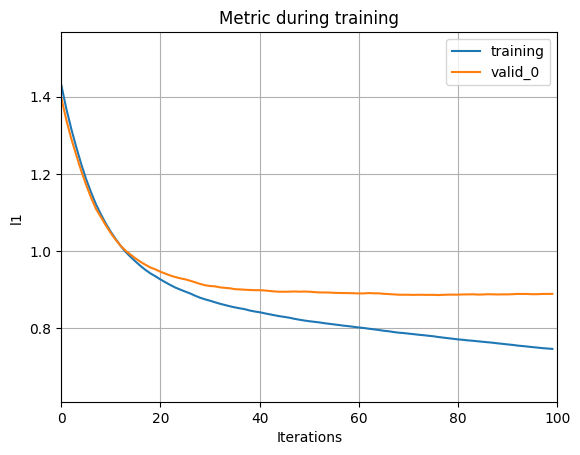

In [24]:
lgb.plot_metric(model,
                metric='l1')

In [25]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)
model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['allelectrons_total', 'density_total', 'allelectrons_average',
       'val_e_average', 'atomicweight_average', 'ionenergy_average',
       'el_neg_chi_average', 'r_vdw_element_average', 'r_cov_element_average',
       'zaratio_average', 'density_av...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index([], dtype='object'))])),
                ('model',
                 LGBMRegressor(bagging_fraction=0.8212955305075269,
                               bagging_freq=1,
                               feature_fraction=0.7456367127221795,
                               lambda_l1=0.00784971333141108,
                               lambda_l2=0.00032294460474756195,
                               min_child_samples=28, n_estimator=100,
                               num_leaves=25, verbose=-1))])

In [26]:
test_data.columns=test_data.columns.str.lower()
test_data.drop(columns=['id'], inplace=True)
test_data.head(2)

,allelectrons_total,density_total,allelectrons_average,val_e_average,atomicweight_average,ionenergy_average,el_neg_chi_average,r_vdw_element_average,r_cov_element_average,zaratio_average,density_average
0,884.0,121.42000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200,0.461899,1.79459
1,90.0,9.93196,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864,0.476196,1.41194


In [27]:
preprocessor.transform(test_data)

,num__allelectrons_total,num__density_total,num__allelectrons_average,num__val_e_average,num__atomicweight_average,num__ionenergy_average,num__el_neg_chi_average,num__r_vdw_element_average,num__r_cov_element_average,num__zaratio_average,num__density_average
0,884.0,121.420000,35.360000,5.280000,82.561240,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459
1,90.0,9.931960,18.000000,5.600000,39.568056,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194
2,116.0,7.767992,11.600000,4.800000,23.231818,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834
3,100.0,9.107996,10.000000,4.800000,20.298893,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466
4,55.0,4.030000,11.000000,4.000000,22.977675,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456
...,...,...,...,...,...,...,...,...,...,...,...
6934,446.0,36.135392,9.636364,4.636364,19.689448,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548
6935,36.0,3.550000,18.000000,4.000000,36.068500,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045
6936,68.0,4.545328,11.333333,5.333333,22.688853,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425
6937,40.0,2.334164,6.666667,4.000000,13.016128,12.700467,2.770000,1.476667,0.616667,0.663797,0.51227
